# Lending Club Default Models

In [1]:
#Libraries
import pandas as pd
import os
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from collections import Counter
from sklearn.model_selection import train_test_split

from scipy.stats import chi2_contingency


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#Display settings 
display = pd.options.display
display.max_columns = 1000
display.max_rows = 1000
display.max_colwidth = 199
display.width = 1000

In [2]:
#files
dir_name = os.getcwd()
file_name = '/Loan_status_2007-2020Q3.gzip'
dir_path = dir_name+file_name

meta_name = '/LCDataDictionary.xlsx'
meta_path = dir_name+meta_name

In [3]:
metaData = pd.read_excel(meta_path, engine='openpyxl') #utf-8 reading issues; openpyxl works best

metaData.style.set_properties(subset=['Description'], **{'width': '1000px'})

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


In [4]:
#Read Data
loanData = pd.read_csv(dir_path, low_memory=False, index_col=0)
loanData.head()
loanData.shape

/Users/arun/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(2925493, 141)

In [5]:
# Encoding the `loan_status`
# status 1: 'Charged Off', 'Late (16-30 days)', 'Late (31-120 days)', 'Default'
# status 0: 'Fully Paid'
keep_status = ['Charged Off', 'Fully Paid', 'Late (16-30 days)', 'Late (31-120 days)', 'Default', 'Current']
loanData = loanData[loanData['loan_status'].isin(keep_status)]

#create a chargeoff flag
loanData['coFlag'] = 1
loanData.loc[loanData['loan_status'].isin(['Fully Paid','Late (16-30 days)','Current']), 'coFlag'] = 0

In [6]:
loanData['loan_status'].value_counts()

Fully Paid            1497783
Current               1031016
Charged Off            362548
Late (31-120 days)      16154
Late (16-30 days)        2719
Default                   433
Name: loan_status, dtype: int64

In [7]:
print(loanData.dtypes)

id                                             object
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                       object
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                                            object
purpose                     

In [8]:
loanData.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,coFlag
0,1077501,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1077501,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,NaN,NaN,3.0,0.0,13648.0,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-2015,171.62,NaN,May-2020,704.0,700.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0
1,1077430,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1077430,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,NaN,NaN,3.0,0.0,1687.0,9.4%,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-2013,119.66,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1
2,1077175,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1077175,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,Na

In [9]:
#Data cleanup
loanData['int_rate'] = loanData['int_rate'].str[:-1].astype(float) #Strip off the %sign
loanData['revol_util'] = loanData['revol_util'].str[:-1].astype(float) #Strip off the %sign

loanData['emp_length'].fillna(value=-1,inplace=True)
loanData['emp_length'].replace(to_replace='< 1 year', value='0', inplace=True)
loanData['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True,regex=True)
loanData['term'] = pd.to_numeric(loanData['term'].str.replace(' months', ''))

In [10]:
#New features

#Length of credit file - thin file elimination
loanData['issue_date']  = loanData["issue_d"].apply(lambda x: datetime.strptime(x, "%b-%Y"))
loanData['oldest_credit_date']  = loanData["earliest_cr_line"].apply(lambda x: datetime.strptime(x, "%b-%Y"))
loanData['credit_hist'] = loanData.issue_date.dt.to_period('M') - loanData.oldest_credit_date.dt.to_period('M')
loanData['credit_hist'] = loanData['credit_hist'].map(lambda x: x.n) 
#loanData[['oldest_credit_date','issue_date','credit_hist']].head()

#FICO
loanData['fico'] = (loanData['fico_range_low']+loanData['fico_range_high'])/2
loanData['refreshFico'] = (loanData['last_fico_range_low']+loanData['last_fico_range_high'])/2

#Funded Ratio
loanData['fund_ratio'] = (loanData['funded_amnt'].div(loanData['loan_amnt']))*100


#Loan to Inc Ratio
loanData['loan_to_inc'] = (loanData['funded_amnt'].div(loanData['annual_inc']))*100

#Log Income - Because incomes are log normal
loanData['log_inc'] = np.log2(loanData['annual_inc'])

#PTI - Understand the Installment is temporal (someone pays higher - cutailments etc.)
loanData['pti'] = (np.where(loanData['installment']>0, loanData['installment'].div(loanData['annual_inc']/12), 0))*100

/Users/arun/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
#Remove temporal variables - since we want to predict propensity to default @Origination
#https://www.kaggle.com/tysonpo/columns-available-at-origination-answer

temporal_vars_remove = ['last_credit_pull_d','last_fico_range_high','last_fico_range_low','total_pymnt',
                        'total_pymnt_inv','recoveries','collection_recovery_fee','out_prncp','out_prncp_inv',
                        'total_rec_prncp','total_rec_int','last_pymnt_d','last_pymnt_amnt','next_pymnt_d',
                        'total_rec_late_fee','hardship_flag','hardship_amount',
                        'orig_projected_additional_accrued_interest','hardship_payoff_balance_amount',
                        'hardship_last_payment_amount','debt_settlement_flag','hardship_type','hardship_reason',
                        'hardship_status','deferral_term','hardship_start_date','hardship_end_date','payment_plan_start_date',
                        'hardship_length','hardship_dpd','hardship_loan_status','installment','pymnt_plan',
                        'acc_now_delinq']

#For simplicity dropping secondary variables - using the application type - individual v/s joint
other_vars_remove  = ['url','oldest_credit_date','earliest_cr_line','last_fico_range_low','last_fico_range_high','policy_code','zip_code',
                      'sec_app_fico_range_low','sec_app_fico_range_high','sec_app_earliest_cr_line','fico_range_low', 'fico_range_high',
                     'annual_inc_joint','dti_joint','verification_status_joint', 'revol_bal_joint','sec_app_inq_last_6mths',
                     'sec_app_mort_acc','sec_app_open_acc','sec_app_revol_util','sec_app_open_act_il',
                      'sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med',
                      'issue_d','loan_status']

print(len(loanData.columns), len(temporal_vars_remove), len(other_vars_remove))

vars_to_remove = temporal_vars_remove + other_vars_remove

loanData.drop(vars_to_remove, axis=1, inplace=True)
#loanDataBkp = loanData.copy()

151 34 26


In [12]:
#Missing Data - we might drop these (after dropping temporal vars)
missing_percent = loanData.isnull().mean().sort_values(ascending=False)
missing_percent.head(50)

mths_since_last_record            0.853940
mths_since_recent_bc_dlq          0.777467
mths_since_last_major_derog       0.752718
mths_since_recent_revol_delinq    0.681699
mths_since_last_delinq            0.525445
il_util                           0.395960
mths_since_rcnt_il                0.317163
all_util                          0.296658
total_cu_tl                       0.296537
inq_last_12m                      0.296537
open_acc_6m                       0.296537
total_bal_il                      0.296537
open_il_24m                       0.296537
open_rv_12m                       0.296537
open_rv_24m                       0.296537
max_bal_bc                        0.296537
open_il_12m                       0.296537
open_act_il                       0.296537
inq_fi                            0.296537
mths_since_recent_inq             0.126379
emp_title                         0.090135
num_tl_120dpd_2m                  0.054478
mo_sin_old_il_acct                0.052414
bc_util    

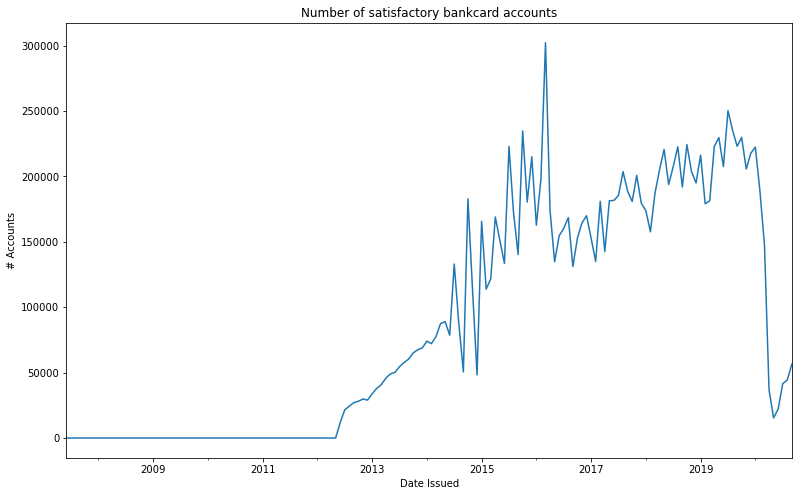

In [13]:
#The below suggests that many of the top missing variables are temporal in the collection sense
#LendingClub likely did not use the missing variables prior to 
grouped = loanData.groupby(by=['issue_date'])
grouped_agg = (grouped['num_bc_sats']
               .agg(np.sum)
               .rename('Accounts'))
grouped_agg_df = grouped_agg.reset_index()
grouped_agg_ts = pd.Series(data=grouped_agg_df['Accounts'].values,
                           index=grouped_agg_df['issue_date'])
del grouped_agg_df

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(111)
grouped_agg_ts.plot(ax=ax)
ax.set_xlabel('Date Issued')
ax.set_ylabel('# Accounts')
ax.set_title('Number of satisfactory bankcard accounts')
plt.show()

In [14]:
loanData.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,title,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,coFlag,issue_date,credit_hist,fico,refreshFico,fund_ratio,loan_to_inc,log_inc,pti
0,1077501,5000.0,5000.0,4975.0,36,10.65,B,B2,NaN,10,RENT,24000.0,Verified,credit_card,Computer,AZ,27.65,0.0,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,NaN,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,2011-12-01,323,737.0,702.0,100.0,20.833333,14.550747,8.143500
1,1077430,2500.0,2500.0,2500.0,60,15.27,C,C4,Ryder,0,RENT,30000.0,Source Verified,car,bike,GA,1.00,0.0,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,NaN,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1,2011-12-01,152,742.0,249.5,100.0,8.333333,14.872675,2.393200
2,1077175,2400.0,2400.0,2400.0,36,15.96,C,C5,NaN,10,RENT,12252.0,Not Verified,small_business,real estate business,IL,8.72,0.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,NaN,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,2011-12-01,121,737.0,737.0,100.0,19.588639,13.580730,8.259549
3,1076863,10000.0,10000.0,10000.0,36,13.49,C,C1,AIR RESOURCES BOARD,10,RENT,49200.0,Source Verified,other,personel,CA,20.00,0.0,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.0,NaN,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,2011-12-01,190,692.0,602.0,100.0,20.325203,15.586371,8.275854
4,1075358,3000.0,3000.0,3000.0,60,12.69,B,B5,University Medical Group,1,RENT,80000.0,Source Verified,other,Personal,OR,17.94,0.0,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,0.0,NaN,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,2011-12-01,191,697.0,682.0,100.0,3.750000,16.287712,1.016850


In [15]:
#loanDataBkp = loanData.copy()

In [16]:
drop_missing = list(missing_percent.head(25).index)
drop_missing

['mths_since_last_record',
 'mths_since_recent_bc_dlq',
 'mths_since_last_major_derog',
 'mths_since_recent_revol_delinq',
 'mths_since_last_delinq',
 'il_util',
 'mths_since_rcnt_il',
 'all_util',
 'total_cu_tl',
 'inq_last_12m',
 'open_acc_6m',
 'total_bal_il',
 'open_il_24m',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'open_il_12m',
 'open_act_il',
 'inq_fi',
 'mths_since_recent_inq',
 'emp_title',
 'num_tl_120dpd_2m',
 'mo_sin_old_il_acct',
 'bc_util',
 'percent_bc_gt_75']

In [17]:
loanData.drop(drop_missing, axis=1, inplace=True)

In [18]:
#Will also drop state, title, sub-grade - creating dummies for every state will blow up the dataset
drop_cat = ['addr_state','title','sub_grade']
loanData.drop(drop_cat, axis=1, inplace=True)

In [19]:
loanData.groupby(['grade']).size()

grade
A    653610
B    854288
C    798085
D    413229
E    138025
F     41463
G     11953
dtype: int64

In [20]:
# define categorical and numerical features
cat_features = ['term', 'home_ownership', 'verification_status', 'purpose', 
                'initial_list_status', 'application_type', 
                'grade'] #, 'addr_state','sub_grade']

num_features = ['loan_amnt', 'int_rate','loan_to_inc', 'emp_length', 'funded_amnt','funded_amnt_inv',
                'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 
                'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 
                'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 
                'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 
                'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 
                'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
                'inq_last_6mths','mths_since_last_delinq',
                'open_acc_6m','open_act_il','open_il_12m','open_il_24m','mths_since_rcnt_il',
                'total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util','inq_fi',
                'total_cu_tl','inq_last_12m','num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
                'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
                'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
                'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
                'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit','mths_since_last_major_derog',
                'total_il_high_credit_limit', 'credit_hist','fund_ratio','fico','refreshFico','log_inc','pti']

num_features = [x for x in num_features if x not in drop_missing]

yVar = ['coFlag']

In [21]:
len(num_features)

56

In [22]:
#More Data cleanup

loanData[num_features] = loanData[num_features].astype(float)

loanData.replace([np.inf, -np.inf], np.nan,inplace=True)

#loanData.replace(np.nan,9999,inplace=True) #We will do NAN replacement later - try   c or median/mean 

In [23]:
#loanData.groupby(['issue_date','coFlag'])['coFlag'].count()

In [24]:
loanData.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,coFlag,issue_date,credit_hist,fico,refreshFico,fund_ratio,loan_to_inc,log_inc,pti
0,1077501,5000.0,5000.0,4975.0,36,10.65,B,10.0,RENT,24000.0,Verified,credit_card,27.65,0.0,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.0,Individual,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,2011-12-01,323.0,737.0,702.0,100.0,20.833333,14.550747,8.143500
1,1077430,2500.0,2500.0,2500.0,60,15.27,C,0.0,RENT,30000.0,Source Verified,car,1.00,0.0,5.0,3.0,0.0,1687.0,9.4,4.0,f,0.0,Individual,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1,2011-12-01,152.0,742.0,249.5,100.0,8.333333,14.872675,2.393200
2,1077175,2400.0,2400.0,2400.0,36,15.96,C,10.0,RENT,12252.0,Not Verified,small_business,8.72,0.0,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.0,Individual,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,2011-12-01,121.0,737.0,737.0,100.0,19.588639,13.580730,8.259549
3,1076863,10000.0,10000.0,10000.0,36,13.49,C,10.0,RENT,49200.0,Source Verified,other,20.00,0.0,1.0,10.0,0.0,5598.0,21.0,37.0,f,0.0,Individual,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,2011-12-01,190.0,692.0,602.0,100.0,20.325203,15.586371,8.275854
4,1075358,3000.0,3000.0,3000.0,60,12.69,B,1.0,RENT,80000.0,Source Verified,other,17.94,0.0,0.0,15.0,0.0,27783.0,53.9,38.0,f,0.0,Individual,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,2011-12-01,191.0,697.0,682.0,100.0,3.750000,16.287712,1.016850


In [25]:
# split into train test and holdout sets
loanData_test_train = loanData[loanData.issue_date <= '2019-09-01']
holdOut = loanData[loanData.issue_date > '2019-09-01'] #Out of time holdout

#Adding 5% of the development data to out of time hold out sample - practical reasons for this; missing dummy (below)
#Some program variables such as grades have changed post 2019
devSet, holdOutAdd  = train_test_split(loanData_test_train, test_size=0.05, random_state=693)#In sample holdout
holdOut = holdOut.append(holdOutAdd) #In + Out sample holdout

trainSet, testSet = train_test_split(devSet,test_size=0.3, random_state=693) #test and train splits

devSet.reset_index(inplace=True)
trainSet.reset_index(inplace=True)
testSet.reset_index(inplace=True)
holdOut.reset_index(inplace=True)

devSet = devSet.drop(['index','issue_date'], axis=1)
trainSet = trainSet.drop(['index','issue_date'], axis=1)
testSet = testSet.drop(['index','issue_date'], axis=1)
holdOut = holdOut.drop(['index','issue_date'], axis=1)

print(len(loanData.index),len(trainSet.index), len(testSet.index), len(holdOut.index))

print(holdOut['coFlag'].value_counts())

#dupRows = loanData[loanData.duplicated()] - have verified there are no dupes
#print(len(dupRows))

2910653 1755124 752197 403332
0    382215
1     21117
Name: coFlag, dtype: int64


In [26]:
loanData.columns.values

array(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'int_rate', 'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'purpose', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'collections_12_mths_ex_med',
       'application_type', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'num_accts_ever_120_pd',
       'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl',
       'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
       'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim

In [27]:
loanData[loanData.funded_amnt!=loanData.loan_amnt].tail()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,coFlag,issue_date,credit_hist,fico,refreshFico,fund_ratio,loan_to_inc,log_inc,pti
188174,1062334,20000.0,12675.0,12675.0,60,14.27,C,10.0,MORTGAGE,60000.0,Source Verified,debt_consolidation,16.64,0.0,0.0,12.0,0.0,18539.0,84.3,26.0,f,0.0,Individual,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,2012-01-01,216.0,712.0,702.0,63.375000,21.125000,15.872675,5.934200
188180,1058291,12000.0,7775.0,7775.0,60,15.27,C,7.0,RENT,50000.0,Verified,credit_card,5.50,0.0,1.0,13.0,0.0,7008.0,37.9,25.0,f,0.0,Individual,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,2012-01-01,107.0,717.0,567.0,64.791667,15.550000,15.609640,4.465920
32403,80749289,18000.0,10000.0,10000.0,36,12.99,C,6.0,RENT,60000.0,Source Verified,small_business,20.45,0.0,1.0,9.0,0.0,15537.0,43.4,12.0,w,0.0,Individual,155.0,28657.0,35800.0,1.0,3184.0,19046.0,0.0,0.0,90.0,4.0,4.0,0.0,43.0,0.0,4.0,5.0,5.0,6.0,2.0,7.0,9.0,5.0,9.0,0.0,0.0,1.0,100.0,0.0,0.0,56761.0,28657.0,31600.0,20045.0,0,2016-06-01,91.0,687.0,712.0,55.555556,16.666667,15.872675,6.738000
32441,79101538,20000.0,10000.0,10000.0,36,7.39,A,10.0,MORTGAGE,55000.0,Verified,debt_consolidation,20.77,0.0,0.0,10.0,0.0,16751.0,61.4,37.0,w,0.0,Joint App,0.0,53218.0,27300.0,3.0,6652.0,4263.0,0.0,0.0,237.0,10.0,10.0,6.0,10.0,1.0,2.0,3.0,5.0,18.0,2.0,8.0,28.0,3.0,10.0,0.0,0.0,2.0,97.3,0.0,0.0,190551.0,18450.0,14000.0,3251.0,0,2016-06-01,239.0,707.0,737.0,50.000000,18.181818,15.747144,6.775855
32706,79041524,20000.0,10000.0,10000.0,60,11.47,B,10.0,MORTGAGE,50000.0,Verified,debt_consolidation,28.13,0.0,0.0,6.0,0.0,15590.0,95.0,15.0,w,0.0,Individual,0.0,54279.0,16350.0,2.0,9046.0,3217.0,0.0,0.0,127.0,11.0,11.0,0.0,11.0,0.0,3.0,4.0,3.0,3.0,8.0,4.0,7.0,4.0,6.0,0.0,0.0,1.0,100.0,0.0,0.0,62990.0,54279.0,9650.0,46640.0,0,2016-06-01,190.0,682.0,667.0,50.000000,20.000000,15.609640,5.274720


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


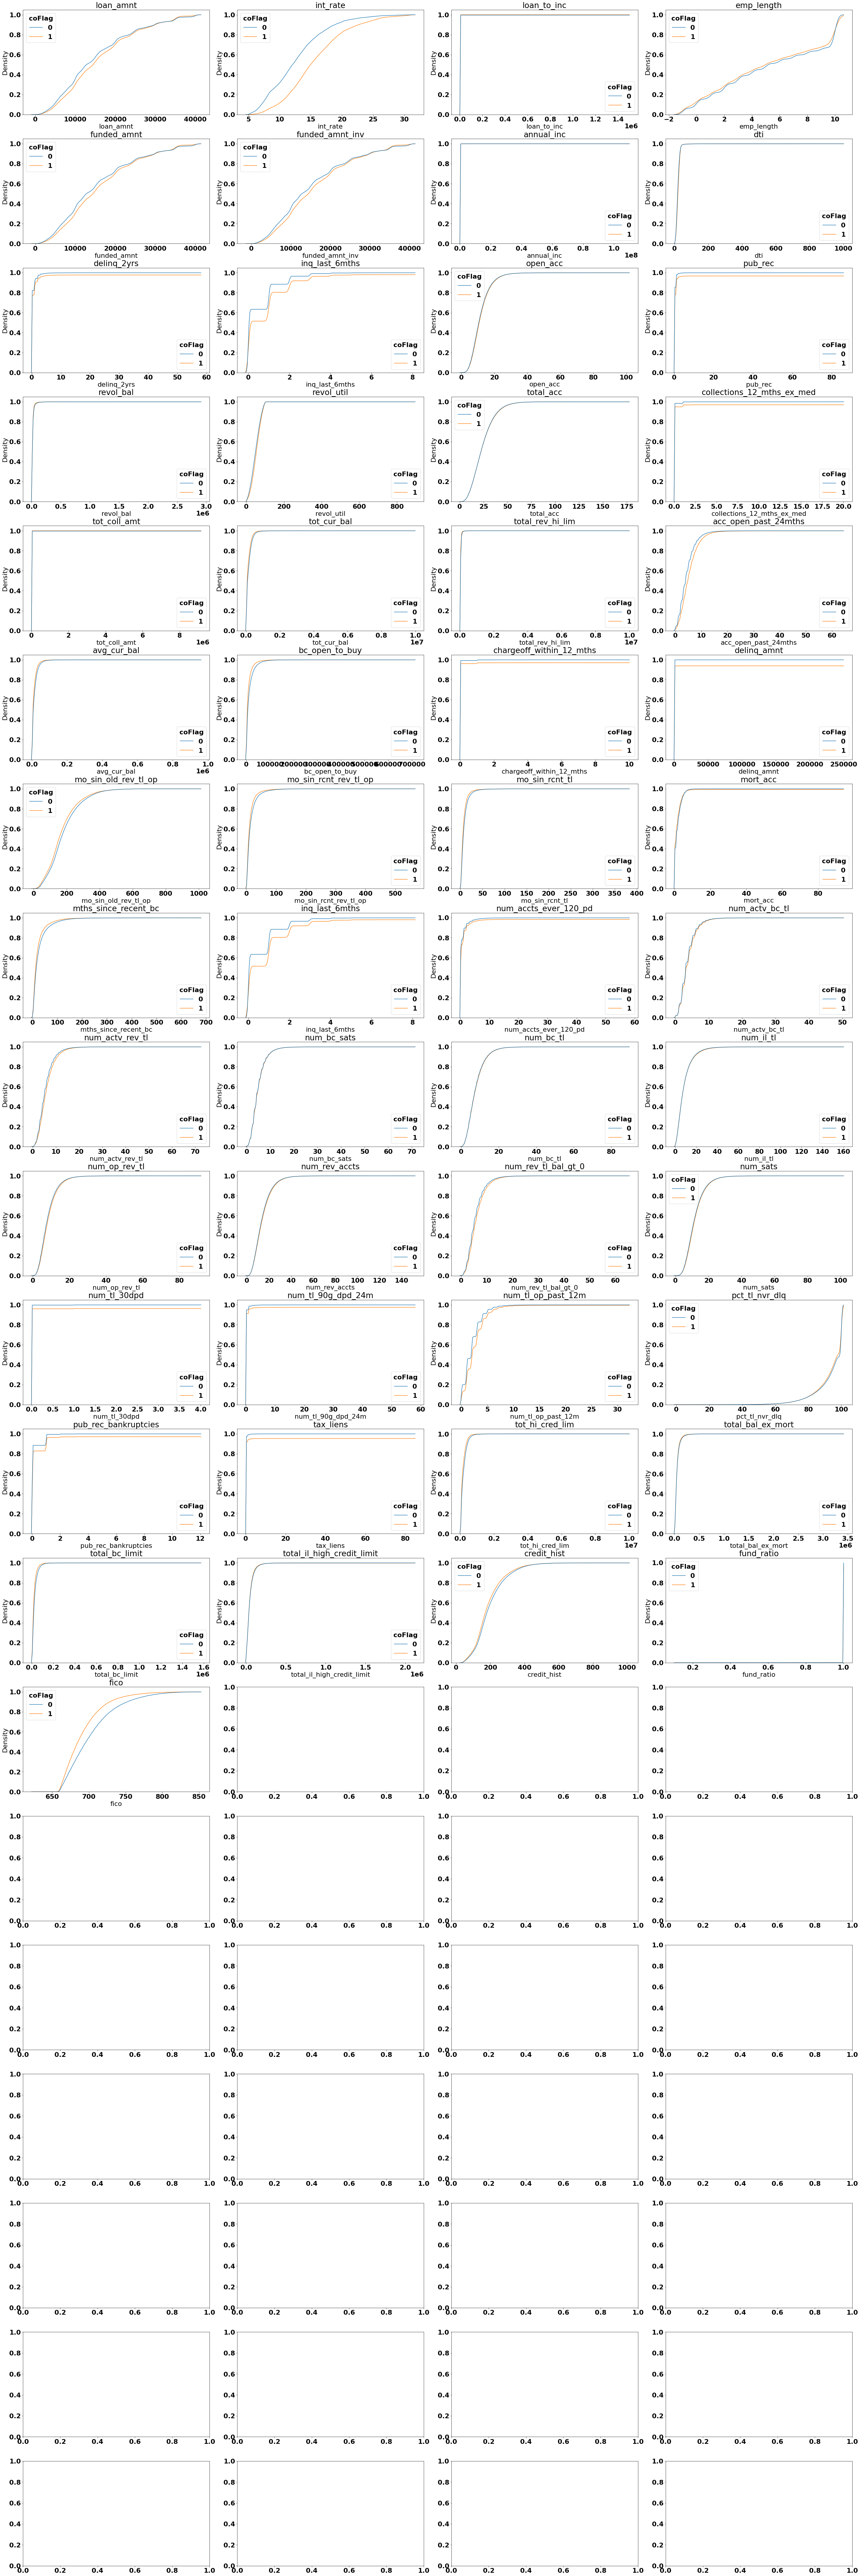

In [28]:
keep_vars = num_features


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

colNum =0
ncols = 4
nrows = 15
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(40, 120))
for row in range(0,nrows):
    for col in range(0,ncols):
            if(colNum < len(keep_vars)-1):
                sns.kdeplot(data=devSet, x = devSet[keep_vars[colNum]], hue="coFlag",cumulative=True,common_norm=False, common_grid=True,ax=axes[row, col])
                axes[row, col].set_title(keep_vars[colNum])
                colNum = colNum+1
                
fig.tight_layout(pad=0, h_pad=.15, w_pad=.15)

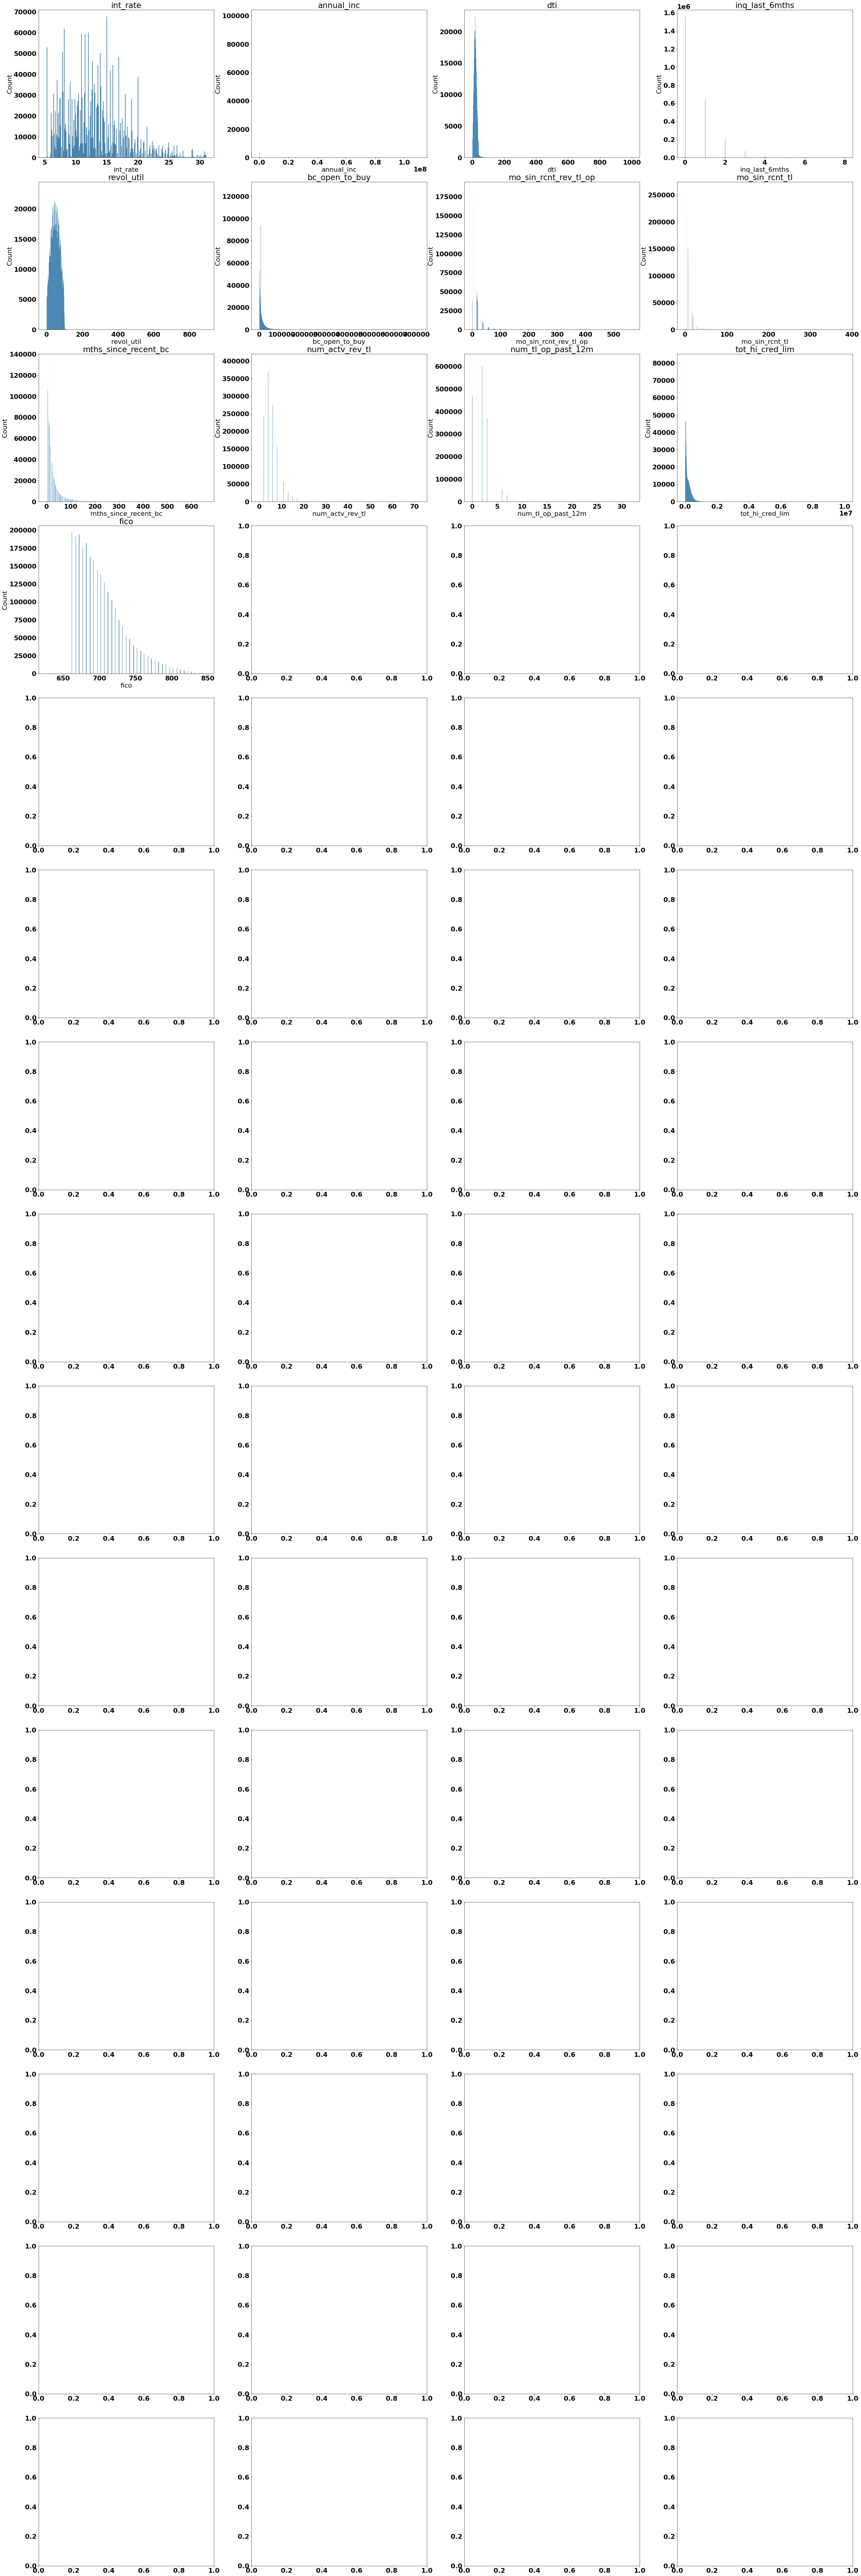

In [91]:
keep_vars = numerical


font = {
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

colNum =0
ncols = 4
nrows = 15
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(40, 120))
for row in range(0,nrows):
    for col in range(0,ncols):
            if(colNum < len(keep_vars)-1):
                sns.histplot(data=devSet, x = devSet[keep_vars[colNum]],ax=axes[row, col])
                axes[row, col].set_title(keep_vars[colNum])
                colNum = colNum+1
                
fig.tight_layout(pad=0, h_pad=.15, w_pad=.15)

In [28]:
len(num_features)

56

In [ ]:
#sns.pairplot(loanData[['fund_ratio','coFlag']], hue="coFlag", height=2.5)
#sns.kdeplot(data=loanData, x="credit_hist", hue="coFlag",cumulative=True, common_norm=False,common_grid=True)

In [ ]:
#Correlation Matrix
corrMatrix = devSet.corr()
y = loanData['coFlag']
correl_vars = ['loan_amnt','loan_to_inc','int_rate','emp_length', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq','total_il_high_credit_limit', 'credit_length']

sns.set(style="white")
df = devSet[correl_vars]
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(df, palette=["red"])
g.map_upper(plt.scatter, hue="coFlag", , palette="Set2", s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

In [29]:
#Correlation Matrix
corrMatrix = devSet.corr()
matrix = np.triu(corrMatrix)
corrMatrix

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,coFlag,credit_hist,fico,refreshFico,fund_ratio,loan_to_inc,log_inc,pti
loan_amnt,1.000000,0.999808,0.999363,0.393040,0.075989,0.099563,0.196152,0.050357,-0.013055,-0.030290,0.180570,-0.061015,0.321799,0.096404,0.194917,-0.022965,-0.004859,0.307759,0.334236,-0.005416,0.223816,0.210527,-0.005631,0.000423,0.162744,0.053942,0.031030,0.215157,0.036407,-0.056106,0.191091,0.147711,0.211929,0.189414,0.083502,0.159699,0.157276,0.147537,1.788986e-01,-0.000426,-0.024474,-0.029759,0.092714,-0.081088,0.004159,0.334365,0.277009,0.374085,0.210869,0.029996,0.156174,0.113260,0.079719,-1.056536e-02,0.000476,0.459066,0.000362
funded_amnt,0.999808,1.000000,0.999596,0.392726,0.076006,0.099570,0.196126,0.050518,-0.012972,-0.030467,0.180699,-0.060906,0.321752,0.096439,0.194840,-0.022914,-0.004859,0.307759,0.334236,-0.005415,0.223817,0.210532,-0.005595,0.000430,0.162744,0.053942,0.031030,0.215156,0.036407,-0.056106,0.191091,0.147711,0.211929,0.189413,0.083502,0.159699,0.157275,0.147537,1.788991e-01,-0.000426,-0.024474,-0.029760,0.092713,-0.080991,0.004212,0.334365,0.277009,0.374090,0.210868,0.029946,0.156207,0.112917,0.079649,7.618992e-03,0.000476,0.458996,0.000363
funded_amnt_inv,0.999363,0.999596,1.000000,0.392960,0.076093,0.099741,0.196046,0.050868,-0.012869,-0.031033,0.180865,-0.060690,0.321581,0.096429,0.194786,-0.022809,-0.004861,0.307778,0.334258,-0.005439,0.223836,0.210590,-0.005534,0.000437,0.162745,0.053962,0.031044,0.215154,0.036422,-0.056126,0.191072,0.147679,0.211922,0.189378,0.083502,0.159682,0.157240,0.147506,1.788866e-01,-0.000439,-0.024491,-0.029781,0.092737,-0.080840,0.004290,0.334390,0.277016,0.374126,0.210878,0.029675,0.156474,0.112581,0.079621,1.012213e-02,0.000477,0.458793,0.000363
term,0.393040,0.392726,0.392960,1.000000,0.353431,0.068514,0.035519,0.057139,-0.013329,-0.003172,0.073798,-0.018191,0.083422,0.059249,0.094075,-0.011313,-0.002525,0.112311,0.072536,0.023719,0.084783,0.022948,-0.003777,-0.001079,0.047250,0.020256,-0.005651,0.104041,0.021442,-0.020961,0.047876,0.052411,0.049591,0.042159,0.075536,0.048508,0.046736,0.052763,7.379863e-02,-0.000405,-0.012678,0.005664,0.046466,-0.011710,-0.009740,0.110767,0.106447,0.072715,0.092423,0.096676,0.049247,0.021700,-0.031263,-1.563119e-02,-0.000140,0.116695,-0.000272
int_rate,0.075989,0.076006,0.076093,0.353431,1.000000,-0.009019,-0.050495,0.117033,0.063314,0.179724,-0.010543,0.052426,-0.029142,0.263846,-0.038216,0.019236,0.003839,-0.083024,-0.184716,0.164155,-0.079977,-0.294813,0.015159,0.004341,-0.128886,-0.087724,-0.108179,-0.090165,-0.071587,0.055476,0.019952,0.081142,-0.061802,-0.082455,0.018057,-0.017152,-0.053860,0.080435,-1.319566e-02,0.012177,0.035556,0.171325,-0.084863,0.054164,0.014023,-0.122174,0.007064,-0.239294,-0.000819,0.218674,-0.111213,-0.411416,-0.313069,4.995885e-03,-0.000025,-0.119876,-0.000022
emp_length,0.099563,0.099570,0.099741,0.068514,-0.009019,1.000000,0.065995,-0.016473,0.029444,0.008664,0.077353,0.013923,0.091643,0.054154,0.114703,-0.005422,-0.000349,0.121434,0.082077,0.035912,0.094504,0.019731,0.006249,0.001869,0.104071,0.011490,-0.024156,0.158028,0.025097,0.009004,0.077649,0.111902,0.068994,0.094494,0.016364,0.097953,0.117335,0.112311,7.580713e-02,0.009060,0.003045,0.029775,-0.021291,0.000821,0.013413,0.132790,0.041647,0.063830,0.033712,-0.020535,0.1095

In [30]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calc/b\u'/late chi-statistic with the target variable
for column in cat_features:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(trainSet['coFlag'], trainSet[column]))
    cramers_v = np.sqrt(chi / trainSet.shape[0]) 
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(p)
    chi2_check.setdefault('Effect Size',[]).append(cramers_v)

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['Effect Size'], ascending = False, ignore_index = True, inplace = True)
print(chi2_result)

#https://stats.stackexchange.com/questions/110718/chi-squared-test-with-scipy-whats-the-difference-between-chi2-contingency-and

               Feature        p-value  Effect Size
0                grade   0.000000e+00     0.239132
1                 term   0.000000e+00     0.096661
2  verification_status   0.000000e+00     0.095097
3       home_ownership   0.000000e+00     0.056451
4              purpose   0.000000e+00     0.050120
5  initial_list_status   0.000000e+00     0.048800
6     application_type  1.274285e-263     0.026182


In [31]:
#Remove the last 2 features  with effect size below 0.09
devSet.drop(['initial_list_status','application_type','purpose','home_ownership'], axis=1, inplace=True)
trainSet.drop(['initial_list_status','application_type','purpose','home_ownership'], axis=1, inplace=True)
testSet.drop(['initial_list_status','application_type','purpose','home_ownership'], axis=1, inplace=True)
holdOut.drop(['initial_list_status','application_type','purpose','home_ownership'], axis=1, inplace=True)

cat_features = [x for x in cat_features if x not in ['initial_list_status','application_type','purpose','home_ownership']]

In [32]:
# function to create dummy variables
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = '_',drop_first=True))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

# apply to our categorical variables
devSet = dummy_creation(devSet, cat_features)
trainSet = dummy_creation(trainSet, cat_features)
testSet = dummy_creation(testSet, cat_features)
holdOut = dummy_creation(holdOut, cat_features)

devSet.drop(cat_features, axis=1, inplace=True)
trainSet.drop(cat_features, axis=1, inplace=True)
testSet.drop(cat_features, axis=1, inplace=True)
holdOut.drop(cat_features, axis=1, inplace=True)

# reindex the dummied test set variables to make sure all the feature columns in the training set are also available in the test set
#trainSet = trainSet.reindex(labels=trainSet.columns, axis=1, fill_value=0)

In [33]:
#Fill missing with KNNImputer - took too long; we'll use median instead
#https://datascience.stackexchange.com/questions/66303/how-to-impute-missing-values-not-the-usual-way
#from sklearn.impute import KNNImputer

#imputer = KNNImputer(n_neighbors=3)
#trainSet = pd.DataFrame(imputer.fit_transform(trainSet),columns = trainSet.columns)
#testSet = pd.DataFrame(imputer.fit_transform(testSet),columns = testSet.columns)
#holdOut = pd.DataFrame(imputer.fit_transform(holdOut),columns = holdOut.columns)
devSet = devSet.fillna(devSet.median())
trainSet = trainSet.fillna(trainSet.median())
testSet = testSet.fillna(testSet.median())
holdOut = holdOut.fillna(holdOut.median())

In [34]:
trainSet.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,coFlag,credit_hist,fico,refreshFico,fund_ratio,loan_to_inc,log_inc,pti,term_60,verification_status_Source Verified,verification_status_Verified,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,13186703,12475.0,12475.0,12475.0,14.16,6.0,27873.64,16.19,0.0,0.0,8.0,0.0,13531.0,30.4,20.0,0.0,0.0,60928.0,44500.0,1.0,7616.0,22207.0,0.0,0.0,177.0,20.0,20.0,3.0,118.0,0.0,3.0,5.0,3.0,7.0,2.0,7.0,15.0,5.0,8.0,0.0,0.0,0.0,100.0,0.0,0.0,99500.0,13531.0,34700.0,0.0,0,177.0,762.0,807.0,100.0,44.755547,14.766614,12.541311,1,1,0,0,1,0,0,0,0
1,129407726,28000.0,28000.0,28000.0,6.71,10.0,135000.00,17.53,0.0,3.0,11.0,2.0,25394.0,64.9,24.0,0.0,0.0,328349.0,39100.0,8.0,29850.0,11246.0,0.0,0.0,265.0,5.0,2.0,2.0,5.0,2.0,3.0,5.0,3.0,4.0,11.0,6.0,11.0,5.0,11.0,0.0,0.0,4.0,91.3,1.0,1.0,370921.0,62211.0,35000.0,65307.0,1,266.0,662.0,582.0,100.0,20.740741,17.042600,7.652089,0,0,1,0,0,0,0,0,0
2,127337588,10000.0,10000.0,10000.0,6.72,3.0,60000.00,15.24,0.0,0.0,5.0,0.0,1924.0,8.0,14.0,0.0,0.0,28682.0,24000.0,2.0,5736.0,11169.0,0.0,0.0,146.0,35.0,20.0,0.0,146.0,0.0,1.0,2.0,1.0,3.0,5.0,4.0,9.0,2.0,5.0,0.0,0.0,0.0,100.0,0.0,0.0,64983.0,28682.0,11300.0,40983.0,0,146.0,802.0,742.0,100.0,16.666667,15.872675,6.150000,0,1,0,0,0,0,0,0,0
3,158313941,3000.0,3000.0,3000.0,14.30,0.0,65000.00,13.16,1.0,0.0,8.0,0.0,1480.0,42.3,27.0,0.0,0.0,22097.0,3500.0,2.0,2762.0,2020.0,1.0,0.0,99.0,36.0,6.0,0.0,36.0,4.0,1.0,1.0,1.0,5.0,19.0,1.0,8.0,1.0,8.0,0.0,1.0,1.0,92.0,0.0,0.0,34563.0,22097.0,3500.0,31063.0,0,142.0,702.0,662.0,100.0,4.615385,15.988152,1.901169,0,1,0,0,1,0,0,0,0
4,9645656,14000.0,14000.0,14000.0,9.67,10.0,80000.00,17.82,0.0,1.0,11.0,0.0,12399.0,37.0,49.0,0.0,0.0,163773.0,33500.0,11.0,14888.0,8361.0,0.0,0.0,154.0,1.0,1.0,3.0,7.0,6.0,2.0,4.0,3.0,12.0,16.0,7.0,30.0,4.0,11.0,0.0,0.0,4.0,87.8,0.0,0.0,219128.0,32377.0,14800.0,45812.0,0,154.0,702.0,712.0,100.0,17.500000,16.287712,6.743700,0,0,0,1,0,0,0,0,0


In [ ]:
#This wont work for non normal columns!!!

# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num, y_train)

# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values,
                                     'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)

# save the top 20 numerical features in a list
top_num_features = ANOVA_F_table.iloc[:20,0].to_list()

# calculate pair-wise correlations between them
corrmat = X_train_num[top_num_features].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat)

# save the names of columns to be dropped in a list
drop_columns_list = ANOVA_F_table.iloc[20:, 0].to_list()
drop_columns_list.extend(chi2_result.iloc[4:, 0].to_list())
drop_columns_list.extend(['out_prncp_inv', 'total_pymnt_inv'])

# function to drop these columns
def col_to_drop(df, columns_list):
    df.drop(columns = columns_list, inplace = True)

# apply to X_train
col_to_drop(X_train, drop_columns_list)

In [ ]:
# Kruskal Wallis test - didn't run
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mstats
# seed the random number generator
seed(1)
numrows = trainSet.shape[0]

# compare samples
for var in num_features:
    H, pval = mstats.kruskalwallis((trainSet[trainSet['coFlag']==1][var].values), (trainSet[trainSet['coFlag']==0][var].values))
    alpha = 0.01
    
c    #print("H-statistic:\t%s\nP-value:\t%s" % (str(H),str(pval)))
    if str(pval) < alpha:
        print(var)

<AxesSubplot:>

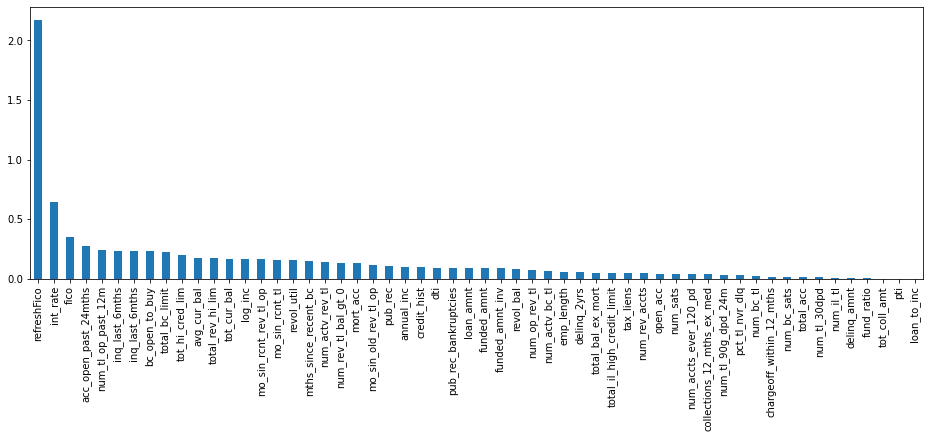

In [35]:
# Cohen's effect size assumes data is normally distributed
def cohen_effect_size(df, target):
    group1 = df[df[target]==0].drop(target, axis=1)
    group2 = df[df[target]==1].drop(target, axis=1)
    diff = group1.mean() - group2.mean()
    var1, var2 = group1.var(), group2.var()
    n1 = group1.shape[0]
    n2 = group2.shape[0]
    pooled_var = ((n1-1) * var1 + (n2-1) * var2) / (n1 + n2 - 2)
    d = diff / np.sqrt(pooled_var)
    return d

feat = num_features
feat.append('coFlag')
df_ces = cohen_effect_size(trainSet[feat], 'coFlag')

df_ces_s = df_ces.abs().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(16, 5))
df_ces_s[::-1].plot.bar(ax=ax)

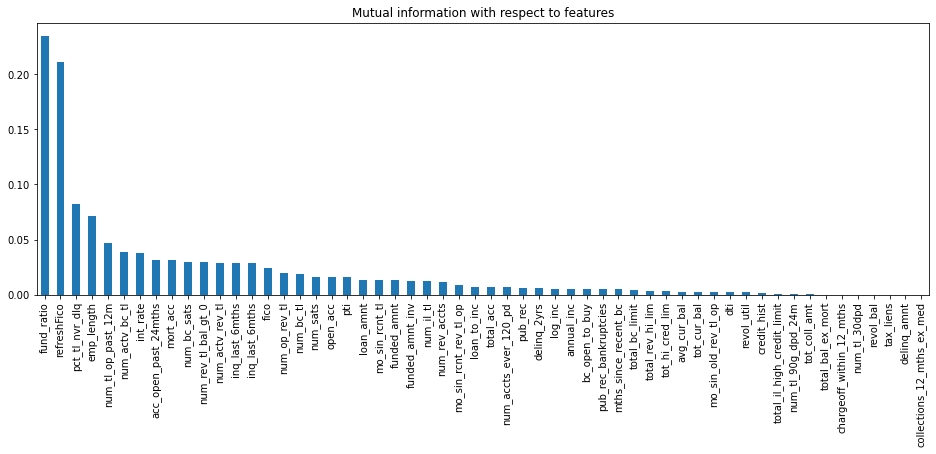

In [38]:
#https://kgptalkie.com/feature-selection-based-on-mutual-information-entropy-gain-for-classification-and-regression-machine-learning-kgp-talkie/

from sklearn.feature_selection import VarianceThreshold, mutual_info_classif

mutual_info = mutual_info_classif(trainSet[num_features], trainSet['coFlag'])
mutual_info = pd.Series(mutual_info)
mutual_info.index = trainSet[num_features].columns

mutual_info.sort_values(ascending=False, inplace = True)

plt.title('Mutual information with respect to features')
mutual_info.plot.bar(figsize = (16,5))
plt.show()

mutual_info = pd.DataFrame(mutual_info)
mutual_info.reset_index(inplace=True)
mutual_info.columns = ['Feature','MI']

In [37]:
#Weight of Evidence - running this only for the continuous/numerical variables
#We used the chi-square earlier for categorical variables

woe_dict = {}
iv = {}

bin_min_size = int(len(trainSet) * 0.05) #every bin must have atleast 5% of total sample
bin_min_size_pct = 0.05
max_bins = 20
target = 'coFlag'

for feature in num_features:
    
    df = trainSet[[feature,target]]

    for bin_size in range(max_bins,1,-1):
        df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
                            .astype(float)

        df_woe_iv = (pd.crosstab(df['bins'],df[target],
                              normalize='columns')
                     .assign(woe=lambda df: np.log(df[1] / df[0]))
                     .assign(iv=lambda df: np.sum(df['woe']*
                                                   (df[1]-df[0]))))
                     #.assign(counts = lambda trainSet np.counts)

        df_woe_iv.reset_index(inplace=True)

        condition1 = np.all(np.diff(df_woe_iv['woe']) > 0) | np.all(np.diff(df_woe_iv['woe']) < 0) #Monotonic WoE
        condition2 = df_woe_iv[0].min() > bin_min_size_pct                     # check if bin size is greater than 5%
        condition3 = ((df_woe_iv[0].all() > 0) and (df_woe_iv[1].all() > 0))   # check if number of good and bad is not equal to 0

        #print(bin_size,df_woe_iv[0].min(),df_woe_iv[0].all(),df_woe_iv[1].all())

        if(condition1 and condition2 and condition3):
            break


    woe_dict[feature] = df_woe_iv
    iv[feature] = df_woe_iv['iv'][0]
    #df_woe_iv

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.qcut(df[feature], q=bin_size,duplicates='drop').apply(lambda x: round(x.left),2) \
<ipython-input-37-22cc4c51eebd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

ValueError: Input array must be 1 dimensional

In [40]:
ivDF = pd.DataFrame(iv.items(), columns=['Feature', 'IV'])

ivDF.sort_values('IV',inplace=True)
conditions = [
    (ivDF['IV'] >= 0.5),
    (ivDF['IV'] < 0.5) & (ivDF['IV'] >= 0.3),
    (ivDF['IV'] < 0.3) & (ivDF['IV'] >= 0.1),
    (ivDF['IV'] < 0.1) & (ivDF['IV'] >= 0.02),
    (ivDF['IV'] < 0.02)]

buckets = ['Suspicious','Strong','Medium','Weak','Useless']

ivDF['ivStrength'] = np.select(conditions, buckets, default='null')

In [41]:
ivDF

,Feature,IV,ivStrength
15,collections_12_mths_ex_med,0.000000,Useless
39,num_tl_30dpd,0.000000,Useless
40,num_tl_90g_dpd_24m,0.000000,Useless
43,pub_rec_bankruptcies,0.000000,Useless
22,chargeoff_within_12_mths,0.000000,Useless
44,tax_liens,0.000000,Useless
11,pub_rec,0.000000,Useless
23,delinq_amnt,0.000000,Useless
50,fund_ratio,0.000000,Useless
14,total_acc,0.000012,Useless


In [43]:
featureSelect = pd.merge(mutual_info,ivDF,on='Feature')

featureSelect.sort_values('MI',ascending=False)

,Feature,MI,IV,ivStrength
0,fund_ratio,0.234825,0.000000,Useless
1,refreshFico,0.211223,3.864270,Suspicious
2,pct_tl_nvr_dlq,0.082603,0.001480,Useless
3,emp_length,0.071632,0.003363,Useless
4,num_tl_op_past_12m,0.046756,0.054847,Weak
5,num_actv_bc_tl,0.038816,0.004952,Useless
6,int_rate,0.037555,0.434024,Strong
7,acc_open_past_24mths,0.031597,0.077384,Weak
8,mort_acc,0.031237,0.019038,Useless
9,num_bc_sats,0.029767,0.000395,Useless


In [42]:
ivDFsubset = ivDF[ivDF.ivStrength.isin(['Suspicious','Useless'])]

num_features_drop = []

num_features_drop.extend([feature for feature in ivDFsubset['Feature']])

num_features_drop

['collections_12_mths_ex_med',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'pub_rec_bankruptcies',
 'chargeoff_within_12_mths',
 'tax_liens',
 'pub_rec',
 'delinq_amnt',
 'fund_ratio',
 'total_acc',
 'num_il_tl',
 'num_bc_sats',
 'num_bc_tl',
 'total_bal_ex_mort',
 'total_il_high_credit_limit',
 'pct_tl_nvr_dlq',
 'num_accts_ever_120_pd',
 'revol_bal',
 'num_rev_accts',
 'delinq_2yrs',
 'tot_coll_amt',
 'num_sats',
 'open_acc',
 'emp_length',
 'num_actv_bc_tl',
 'num_op_rev_tl',
 'credit_hist',
 'funded_amnt_inv',
 'loan_amnt',
 'funded_amnt',
 'mo_sin_old_rev_tl_op',
 'mort_acc',
 'num_rev_tl_bal_gt_0',
 'refreshFico']

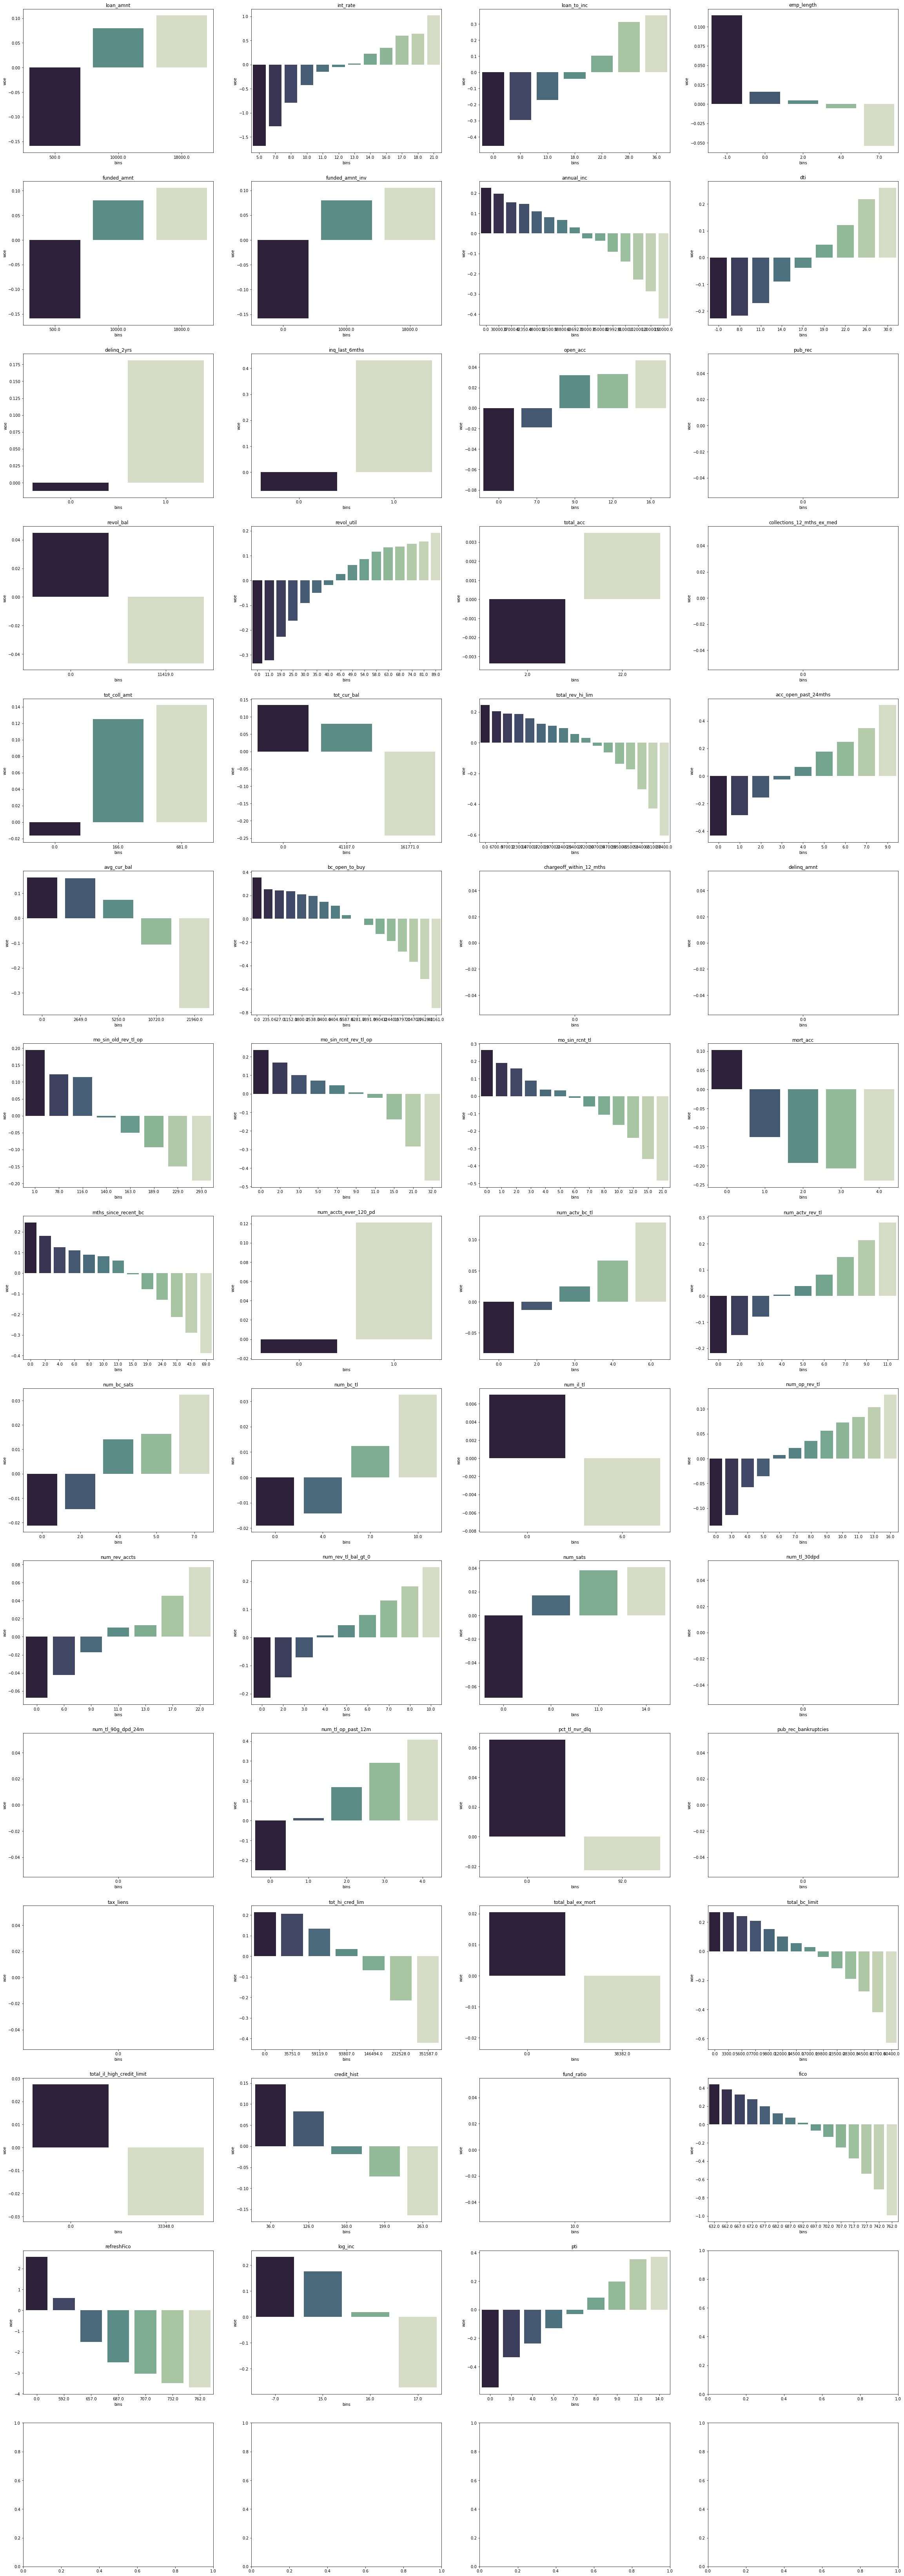

In [43]:
import matplotlib.pyplot as plt

num_figs = len(woe_dict)
rowcount = 0
ncols = 4
nrows = 15
feature_list = list(woe_dict.keys())

fig2, ax2 = plt.subplots(ncols=ncols, nrows=nrows, figsize=(40, 120))
while(rowcount < num_figs):
    for row in range(0,nrows):
        for col in range(0,ncols):
            if(rowcount > num_figs-1):
                break
            feature = feature_list[rowcount]
            df_woe_iv = woe_dict[feature]
            palette = sns.cubehelix_palette(n_colors=len(df_woe_iv.index), start=.5, rot=-.75, reverse=True)
            sns.barplot(x='bins', y='woe', data=df_woe_iv, palette=palette,ax=ax2[row, col])
            #ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=90)
            ax2[row, col].set_title(feature)
            rowcount = rowcount+1

In [ ]:
#Build this out later
df_tenure = iv.group_by_feature(feats_dict['tenure'])
df_tenure['total'] = 1
df_tenure['good_share'] = df_tenure['good'] / df_tenure['count']

fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='tenure', y='total', data=df_tenure, color='#a9c6a3')
sns.barplot(x='tenure', y='good_share', data=df_tenure, color='#4a6a7c')
ax.set_title("Share of 'goods' in total")
plt.show()

In [ ]:
df.groupby('bin').agg({feature: 'count', target: 'sum'})

In [44]:
#Keep only relevant information value numerical vars

devSet.drop(num_features_drop, axis=1, inplace=True)
trainSet.drop(num_features_drop, axis=1, inplace=True)
testSet.drop(num_features_drop, axis=1, inplace=True)
holdOut.drop(num_features_drop, axis=1, inplace=True)


devSet.reset_index(inplace=True)
trainSet.reset_index(inplace=True)
testSet.reset_index(inplace=True)
holdOut.reset_index(inplace=True)

devSet.drop('index', axis=1, inplace=True)
trainSet.drop('index', axis=1, inplace=True)
testSet.drop('index', axis=1, inplace=True)
holdOut.drop('index', axis=1, inplace=True)

In [45]:
devSet.drop('id', axis=1, inplace=True)
trainSet.drop('id', axis=1, inplace=True)
testSet.drop('id', axis=1, inplace=True)
holdOut.drop('id', axis=1, inplace=True)

In [46]:
testSet.head()

,int_rate,annual_inc,dti,inq_last_6mths,revol_util,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_bc,num_actv_rev_tl,num_tl_op_past_12m,tot_hi_cred_lim,total_bc_limit,coFlag,fico,loan_to_inc,log_inc,pti,term_60,verification_status_Source Verified,verification_status_Verified,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,8.24,80000.0,19.95,0.0,44.4,288938.0,25200.0,3.0,28894.0,9019.0,71.0,6.0,71.0,4.0,2.0,332240.0,20200.0,0,727.0,31.250000,16.287712,11.792850,0,0,0,1,0,0,0,0,0
1,13.11,42198.0,12.37,1.0,39.4,79845.0,26200.0,3.0,7363.0,3002.0,9.0,6.0,18.0,5.0,2.0,116413.0,5200.0,0,692.0,15.403574,15.364887,6.238021,0,0,0,1,0,0,0,0,0
2,22.70,61000.0,18.06,2.0,50.3,76795.0,79000.0,3.0,7680.0,24812.0,4.0,4.0,4.0,4.0,3.0,127174.0,41700.0,1,732.0,31.967213,15.896522,10.748066,1,0,1,0,0,0,1,0,0
3,10.99,54000.0,11.97,1.0,78.3,14087.0,16100.0,2.0,1761.0,124.0,20.0,20.0,68.0,7.0,0.0,19100.0,9100.0,1,697.0,27.777778,15.720672,10.911333,0,1,0,1,0,0,0,0,0
4,7.07,45850.0,3.59,0.0,12.9,5027.0,39000.0,6.0,628.0,13559.0,9.0,9.0,9.0,4.0,3.0,39000.0,17800.0,0,727.0,8.724100,15.484634,3.235943,0,0,1,0,0,0,0,0,0


In [50]:
numerical = [x for x in num_features if x not in num_features_drop]

In [55]:
numerical = ['int_rate',
 'loan_to_inc',
 'annual_inc',
 'dti',
 'inq_last_6mths',
 'revol_util',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mths_since_recent_bc',
 'num_actv_rev_tl',
 'num_tl_op_past_12m',
 'tot_hi_cred_lim',
 'total_bc_limit',
 'fico',
 'log_inc',
 'pti',
 'coFlag']

In [56]:
corrMatrix = trainSet[numerical].corr()
matrix = np.triu(corrMatrix)
corrMatrix

,int_rate,loan_to_inc,annual_inc,dti,inq_last_6mths,revol_util,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_bc,num_actv_rev_tl,num_tl_op_past_12m,tot_hi_cred_lim,total_bc_limit,fico,log_inc,pti,coFlag
int_rate,1.000000,-0.000032,-0.068853,0.117765,0.179814,0.263479,-0.081130,-0.182999,0.163770,-0.078252,-0.290934,-0.086349,-0.107031,-0.070241,0.081013,0.169546,-0.120115,-0.236983,-0.411300,-0.119510,-0.000028,0.218533
loan_to_inc,-0.000032,1.000000,-0.001088,0.000452,-0.000605,0.000915,0.000488,-0.000716,0.000080,0.002204,-0.000487,-0.000486,-0.000501,-0.000535,-0.000840,-0.000064,0.000280,-0.000689,-0.000709,-0.027722,0.999790,-0.000274
annual_inc,-0.068853,-0.001088,1.000000,-0.115009,0.029100,0.040123,0.352769,0.265452,0.059744,0.261634,0.148073,0.023000,-0.031348,0.018569,0.085909,0.050096,0.370264,0.252624,0.046875,0.633096,-0.001035,-0.034673
dti,0.117765,0.000452,-0.115009,1.000000,-0.012905,0.105760,0.030254,0.065324,0.074883,-0.043654,-0.024871,0.000943,-0.045969,0.008011,0.148389,0.038166,0.040404,0.043269,-0.015788,-0.248135,0.000401,0.032037
inq_last_6mths,0.179814,-0.000605,0.029100,-0.012905,1.000000,-0.082538,0.026395,0.020049,0.282596,-0.027840,0.017585,-0.189397,-0.227625,-0.131009,0.121315,0.329068,0.028056,-0.002935,-0.091167,0.051686,-0.000580,0.081595
revol_util,0.263479,0.000915,0.040123,0.105760,-0.082538,1.000000,0.084161,-0.139425,-0.221104,0.125959,-0.476159,0.171733,0.163563,0.143275,0.111604,-0.216586,0.025796,-0.178264,-0.486615,0.079052,0.000938,0.053951
tot_cur_bal,-0.081130,0.000488,0.352769,0.030254,0.026395,0.084161,1.000000,0.400892,0.119050,0.825661,0.167890,0.032910,-0.080644,0.045775,0.107812,0.102717,0.976749,0.314659,0.107392,0.499559,0.000459,-0.058001
total_rev_hi_lim,-0.182999,-0.000716,0.265452,0.065324,0.020049,-0.139425,0.400892,1.000000,0.120373,0.186980,0.634440,-0.060224,-0.048380,-0.055488,0.352261,0.092396,0.495545,0.769615,0.277711,0.367103,-0.000713,-0.060148
acc_open_past_24mths,0.163770,0.000080,0.059744,0.074883,0.282596,-0.221104,0.119050,0.120373,1.000000,-0.061219,0.139572,-0.409040,-0.452610,-0.337779,0.339965,0.766705,0.127595,0.078990,-0.102021,0.116429,0.000099,0.096722
avg_cur_bal,-0.078252,0.002204,0.261634,-0.043654,-0.027840,0.125959,0.825661,0.186980,-0.061219,1.000000,0.030422,0.159628,0.020757,0.151658,-0.150078,-0.037298,0.785257,0.122268,0.100213,0.375104,0.002171,-0.060308


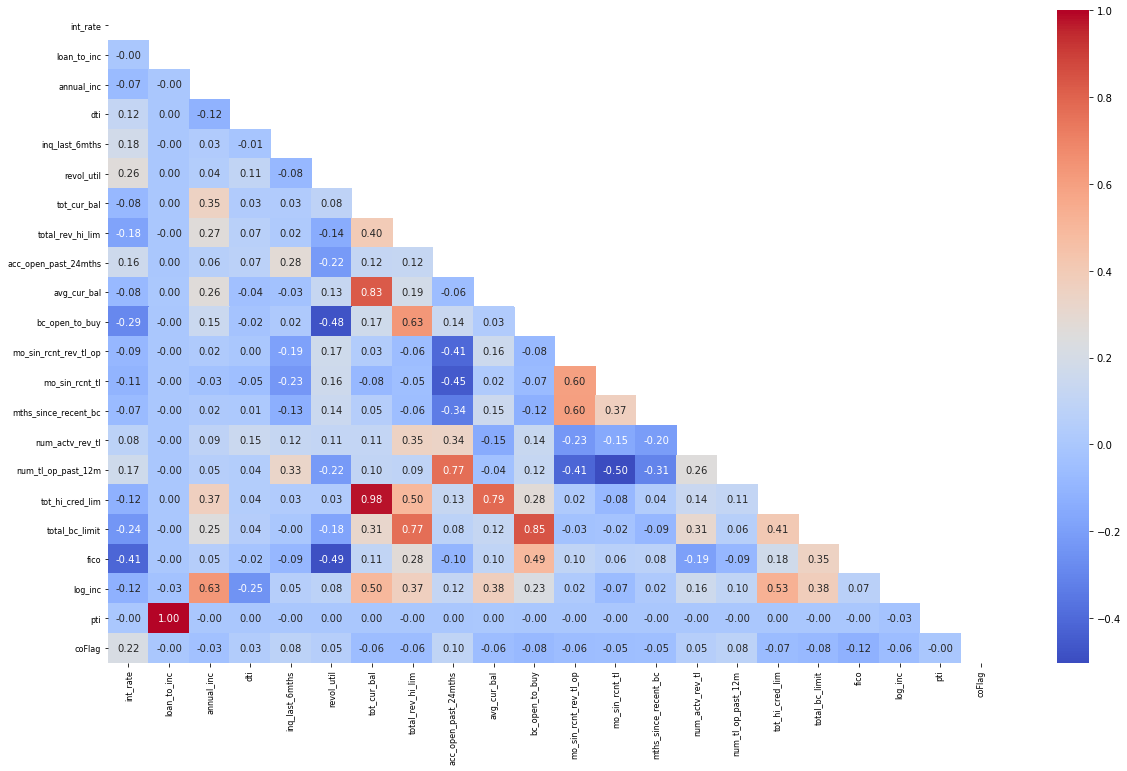

In [57]:
import matplotlib.pyplot as plt


fig2, ax2 = plt.subplots(figsize=(20, 12))
ax2 = sns.heatmap(corrMatrix,annot=True, fmt = "0.2f", cmap = "coolwarm",ax=ax2, mask=matrix,annot_kws={"size":10},
           vmin=corrMatrix.values.min(), vmax=corrMatrix.values.max())

x = ax2.set_xticklabels(ax2.get_xmajorticklabels(), fontsize = 8, rotation=90)
y = ax2.set_yticklabels(ax2.get_ymajorticklabels(), fontsize = 8, rotation=360)
plt.show()

In [58]:
#High Correlations
# 1. tot_cur_bal and tot_high_cred_lim
# 2. tot_cur_bal and avg_cur_bal
# 3. tot_rev_hi_lim and total_bc_lim
# 4. acc_open_past_24mths and num_tl_op_past_12m
# 5. avg_cur_bal and tot_high_cred_lim
# 6. bc_open_to_buy and total_bc_limit
# 7. pti and loan_to_inc

#Based on a look at the Information Value and the Mutual Information Value, we'll drop a few of the highly correlated
#variabes

drop_high_corr = ['acc_open_past_24mths','total_bc_limit','total_rev_hi_lim','tot_cur_bal','avg_cur_bal','pti','log_inc']

devSet.drop(drop_high_corr, axis=1, inplace=True)
trainSet.drop(drop_high_corr, axis=1, inplace=True)
testSet.drop(drop_high_corr, axis=1, inplace=True)
holdOut.drop(drop_high_corr, axis=1, inplace=True)


devSet.reset_index(inplace=True)
trainSet.reset_index(inplace=True)
testSet.reset_index(inplace=True)
holdOut.reset_index(inplace=True)

devSet.drop('index', axis=1, inplace=True)
trainSet.drop('index', axis=1, inplace=True)
testSet.drop('index', axis=1, inplace=True)
holdOut.drop('index', axis=1, inplace=True)

In [59]:
trainSet.head()

,int_rate,annual_inc,dti,inq_last_6mths,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_bc,num_actv_rev_tl,num_tl_op_past_12m,tot_hi_cred_lim,coFlag,fico,loan_to_inc,term_60,verification_status_Source Verified,verification_status_Verified,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,14.16,27873.64,16.19,0.0,30.4,22207.0,20.0,20.0,118.0,5.0,0.0,99500.0,0,762.0,44.755547,1,1,0,0,1,0,0,0,0
1,6.71,135000.00,17.53,3.0,64.9,11246.0,5.0,2.0,5.0,5.0,4.0,370921.0,1,662.0,20.740741,0,0,1,0,0,0,0,0,0
2,6.72,60000.00,15.24,0.0,8.0,11169.0,35.0,20.0,146.0,2.0,0.0,64983.0,0,802.0,16.666667,0,1,0,0,0,0,0,0,0
3,14.30,65000.00,13.16,0.0,42.3,2020.0,36.0,6.0,36.0,1.0,1.0,34563.0,0,702.0,4.615385,0,1,0,0,1,0,0,0,0
4,9.67,80000.00,17.82,1.0,37.0,8361.0,1.0,1.0,7.0,4.0,4.0,219128.0,0,702.0,17.500000,0,0,0,1,0,0,0,0,0


In [60]:
#Fit Models!
Xtrain = trainSet.drop('coFlag', axis=1)
ytrain = trainSet['coFlag']
numerical = Xtrain.columns[(Xtrain.dtypes == 'float64')].tolist()
sc = StandardScaler()
Xtrain[numerical] = sc.fit_transform(Xtrain[numerical])

model = LogisticRegression(solver='sag',class_weight=None,max_iter=100)

In [61]:
Xtrain.head()

,int_rate,annual_inc,dti,inq_last_6mths,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_bc,num_actv_rev_tl,num_tl_op_past_12m,tot_hi_cred_lim,fico,loan_to_inc,term_60,verification_status_Source Verified,verification_status_Verified,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,0.231378,-0.622685,-0.191648,-0.648767,-0.769392,0.599458,0.332545,1.290064,2.902046,-0.177315,-1.140462,-0.440768,1.797890,-0.000907,1,1,0,0,1,0,0,0,0
1,-1.306685,0.680481,-0.103283,2.865387,0.621716,-0.042207,-0.519905,-0.692897,-0.612964,-0.177315,1.064973,1.054714,-1.190238,-0.001118,0,0,1,0,0,0,0,0,0
2,-1.304620,-0.231875,-0.254295,-0.648767,-1.672603,-0.046715,1.184995,1.290064,3.773023,-1.071305,-1.140462,-0.630951,2.993142,-0.001154,0,1,0,0,0,0,0,0,0
3,0.260281,-0.171052,-0.391459,-0.648767,-0.289560,-0.582304,1.241825,-0.252239,0.351331,-1.369302,-0.589103,-0.798560,0.005013,-0.001260,0,1,0,0,1,0,0,0,0
4,-0.695589,0.011420,-0.084159,0.522618,-0.503267,-0.211097,-0.747225,-0.803062,-0.550752,-0.475312,1.064973,0.218361,0.005013,-0.001147,0,0,0,1,0,0,0,0,0


In [62]:
Xtest = testSet.drop('coFlag', axis=1)
ytest = testSet['coFlag']

Xtest[numerical] = sc.fit_transform(Xtest[numerical])
Xtest.head()

,int_rate,annual_inc,dti,inq_last_6mths,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_bc,num_actv_rev_tl,num_tl_op_past_12m,tot_hi_cred_lim,fico,loan_to_inc,term_60,verification_status_Source Verified,verification_status_Verified,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,-0.990290,0.005246,0.055977,-0.647929,-0.202106,-0.172126,3.209905,-0.251237,1.440754,-0.474617,-0.035288,0.844790,0.749515,-0.002996,0,0,0,1,0,0,0,0,0
1,0.015693,-0.223853,-0.435777,0.523105,-0.403535,-0.524449,-0.292695,-0.251237,-0.208714,-0.176646,-0.035288,-0.346754,-0.294501,-0.004741,0,0,0,1,0,0,0,0,0
2,1.996674,-0.109903,-0.066637,1.694138,0.035581,0.752626,-0.575163,-0.469166,-0.644422,-0.474617,0.517129,-0.287344,0.898660,-0.002917,1,0,1,0,0,0,1,0,0
3,-0.422229,-0.152327,-0.461727,0.523105,1.163586,-0.692969,0.328734,1.274269,1.347387,0.419295,-1.140122,-0.884002,-0.145356,-0.003378,0,1,0,1,0,0,0,0,0
4,-1.231973,-0.201720,-1.005382,-0.647929,-1.471111,0.093712,-0.292695,0.075657,-0.488812,-0.474617,0.517129,-0.774137,0.749515,-0.005476,0,0,1,0,0,0,0,0,0


In [63]:
XHold = holdOut.drop('coFlag', axis=1)
yHold = holdOut['coFlag']

XHold[numerical] = sc.fit_transform(XHold[numerical])

XDev = devSet.drop('coFlag', axis=1)
yDev = devSet['coFlag']

XDev[numerical] = sc.fit_transform(XDev[numerical])


In [64]:
XHold.head()

,int_rate,annual_inc,dti,inq_last_6mths,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_bc,num_actv_rev_tl,num_tl_op_past_12m,tot_hi_cred_lim,fico,loan_to_inc,term_60,verification_status_Source Verified,verification_status_Verified,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,0.946420,-0.352864,-0.294071,0.572517,1.422825,-0.346380,-0.338061,0.082397,-0.341552,-1.327486,0.490185,-0.887442,-0.562354,-0.005791,0,1,0,0,1,0,0,0,0
1,-0.129094,-0.724729,3.233341,1.802166,0.528255,-0.699652,-0.602436,-0.478322,-0.555390,-0.168100,-0.045738,-0.694856,-1.130341,0.004637,0,0,1,1,0,0,0,0,0
2,0.442902,-0.011150,0.795583,-0.657132,0.015369,2.327264,-0.443811,-0.141891,-0.127714,3.599907,-0.045738,0.803606,-0.278360,-0.003668,1,1,0,0,1,0,0,0,0
3,-1.325453,-0.021200,0.007637,0.572517,-0.684383,0.561979,2.940188,0.530972,1.399703,-1.037640,-1.117584,-0.059376,2.277582,-0.004857,0,0,1,0,0,0,0,0,0
4,-1.212665,0.441119,0.433095,-0.657132,-1.034260,0.118859,-0.602436,-0.590466,-0.647035,-0.457947,1.562032,1.077271,1.851592,-0.005673,0,1,0,0,0,0,0,0,0


In [65]:
model.fit(Xtrain, ytrain)

scores = cross_val_score(model, Xtrain - np.min(Xtrain) + 1, ytrain, cv=5)
print(scores, np.mean(scores))

/Users/arun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/arun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/arun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/arun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/arun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: 

[0.85697885 0.85707571 0.85714408 0.85702728 0.85733454] 0.8571120902126864


/Users/arun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [66]:
def createROC(model, X, y, Xtest, ytest):
    false_p, true_p = [], [] ##false postives and true positives

    #model.fit(X, y)

    fp, tp, threshold = roc_curve(ytest, model.predict_proba(Xtest)[:,1]) ##roc_curve function

    true_p.append(tp)
    false_p.append(fp)
    return true_p, false_p ##returning the true postive and false positive

In [173]:
tp, fp = createROC(model, Xtrain - np.min(Xtrain) + 1, ytrain, Xtest - np.min(Xtest) + 1, ytest)

In [109]:
fp, tp, threshold = roc_curve(ytrain, model.predict_proba(Xtrain)[:,1])

Text(0, 0.5, 'True Positive & False Positive Rates')

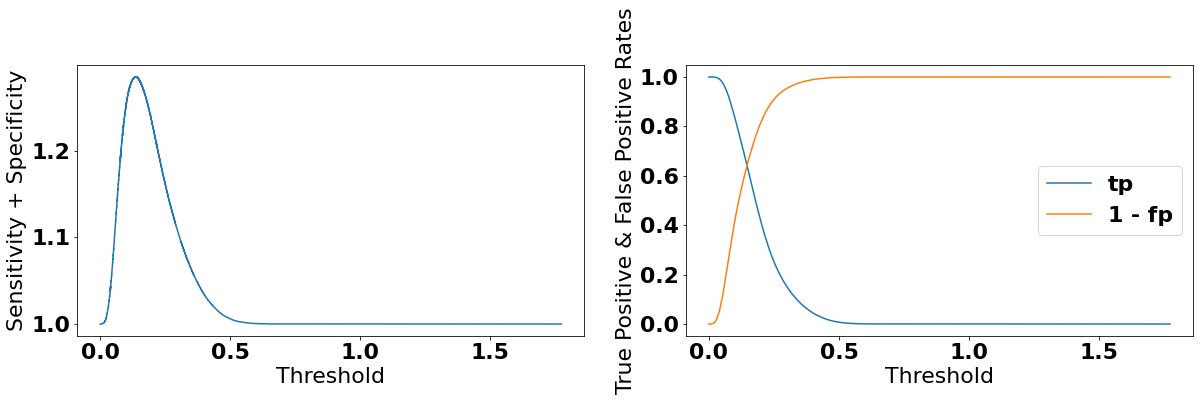

In [110]:
#https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

ax[0].plot(threshold, tp + (1 - fp))
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Sensitivity + Specificity')

ax[1].plot(threshold, tp, label="tp")
ax[1].plot(threshold, 1 - fp, label="1 - fp")
ax[1].legend()
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('True Positive & False Positive Rates')

In [111]:
#https://en.wikipedia.org/wiki/Youden%27s_J_statistic

Sensitivity = tp
Specificity = 1-fp

Youden_J_stat = Sensitivity+Specificity-1

best_threshold_loc = np.argmax(Youden_J_stat)

best_threshold = threshold[best_threshold_loc]
print('Best threshold:', best_threshold)

Best threshold: 0.13525755295995998


In [112]:
from sklearn.metrics import precision_score,recall_score,f1_score


def plot_ROC_Confusion(X,y,model,threshold):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

    lr_probs = model.predict_proba(X)[:,1]
    ns_probs = [0 for _ in range(len(y))]
    ns_auc = roc_auc_score(y, ns_probs)
    lr_auc = roc_auc_score(y, lr_probs)
    
    predict = np.where(lr_probs >= threshold, 1, 0)
    precision = f1_score(y, predict, average='binary')
    recall = f1_score(y, predict, average='binary')
    f1 = f1_score(y, predict, average='binary')
    model_name = model.__class__.__name__
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print(model_name+': ROC AUC=%.3f' % (lr_auc))
    print('Precision=%.2f, Recall=%.2f, F1=%.2f' % (precision,recall,f1))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    # plot the roc curve for the model
    axes[0].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    axes[0].plot(fp, tp, linestyle='-', label=model_name)
    axes[0].set_xlabel('True Positive Rate')
    axes[0].set_ylabel('False Positive Rate')
    axes[0].legend()

    
    confusion = confusion_matrix(y, predict).T
    confusion = (confusion.astype('float')/confusion.sum(axis=0))

    ax[1] = sns.heatmap(confusion, annot=True, cmap='Blues', ax=axes[1]);
    ax[1].set_xlabel('Actuals')
    ax[1].set_ylabel('Predicted')
    ax[1].axis('equal')

    axes[0].set_xlim(0,1)
    axes[0].set_ylim(0,1)

No Skill: ROC AUC=0.500
LogisticRegression: ROC AUC=0.695
Precision=0.33, Recall=0.33, F1=0.33


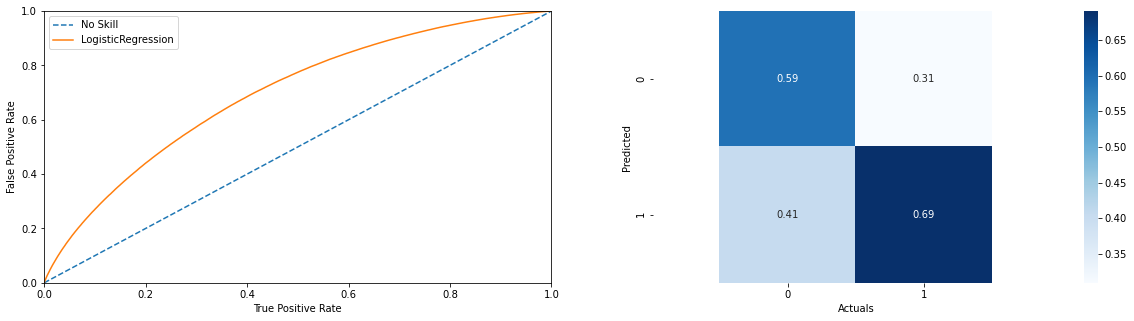

In [117]:
plt.rcParams["font.weight"] = 'normal'
plt.rcParams["font.family"] = 'sans'
plt.rcParams["font.size"]  =  10.0
plot_ROC_Confusion(Xtrain,ytrain,model,best_threshold)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.696
Precision=0.34, Recall=0.34, F1=0.34


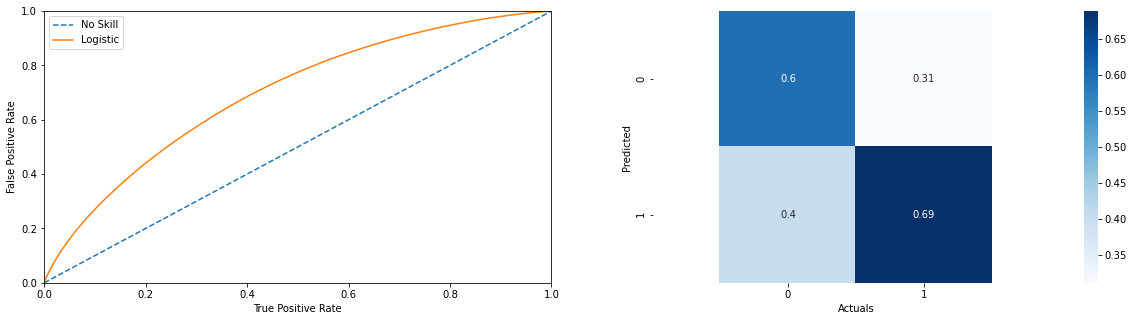

In [72]:
plot_ROC_Confusion(Xtest,ytest,model,best_threshold)

In [73]:
model_unbalanced = model

In [74]:
pd.DataFrame({"Feature":Xtrain.columns.tolist(),"Coefficients":model.coef_[0]})

,Feature,Coefficients
0,int_rate,0.357940
1,annual_inc,-0.066583
2,dti,0.017749
3,inq_last_6mths,0.084775
4,revol_util,-0.000141
5,bc_open_to_buy,-0.086856
6,mo_sin_rcnt_rev_tl_op,-0.020459
7,mo_sin_rcnt_tl,-0.032282
8,mths_since_recent_bc,-0.061607
9,num_actv_rev_tl,0.054334


In [75]:
#Let us try SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

Xtrain2 = trainSet.drop('coFlag', axis=1)
ytrain2 = trainSet['coFlag']
numerical = Xtrain.columns[(Xtrain.dtypes == 'float64')].tolist()
sc = StandardScaler()
Xtrain2[numerical] = sc.fit_transform(Xtrain2[numerical])

over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train, y_train = pipeline.fit_resample(Xtrain2, ytrain2)

#X_train, y_train = smt.fit_resample(Xtrain, ytrain)

In [76]:
print(X_train.shape,Xtrain.shape)
print(np.bincount(y_train),np.bincount(ytrain))

X_train.head()

(902754, 23) (1755124, 23)
[601836 300918] [1504593  250531]


,int_rate,annual_inc,dti,inq_last_6mths,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_bc,num_actv_rev_tl,num_tl_op_past_12m,tot_hi_cred_lim,fico,loan_to_inc,term_60,verification_status_Source Verified,verification_status_Verified,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,-0.559331,-0.256643,0.047070,-0.648767,0.879776,-0.645528,0.559865,1.730722,-0.021945,0.418679,-1.140462,-0.377069,-1.190238,-0.001242,0,1,0,1,0,0,0,0,0
1,1.641440,0.011420,1.156251,1.694002,1.262835,-0.681999,-0.463075,-0.252239,-0.581858,0.716676,-0.037745,0.950088,-0.891425,-0.001094,1,0,1,0,0,0,1,0,0
2,0.107507,0.558834,-0.059760,-0.648767,1.339447,-0.501693,0.218885,1.069735,-0.208582,0.120682,-1.140462,1.660062,-0.443206,-0.001090,1,0,1,0,1,0,0,0,0
3,0.196281,-0.724548,-0.297819,-0.648767,-0.491170,-0.057545,-0.178925,0.298583,-0.426326,0.120682,-0.037745,-0.883758,-0.592612,-0.001041,0,1,0,0,1,0,0,0,0
4,-0.357009,-0.207546,-0.099986,0.522618,-1.495187,-0.256759,-0.690395,-0.692897,-0.706283,-0.177315,1.064973,-0.259093,0.303826,-0.001233,0,0,0,1,0,0,0,0,0


In [77]:
np.bincount(ytrain)

array([1504593,  250531])

In [79]:
modelSmote = LogisticRegression(solver='sag',class_weight=None,max_iter = 4000)

modelSmote.fit(X_train, y_train)


LogisticRegression(max_iter=4000, solver='sag')

In [ ]:

scores = cross_val_score(modelSmote, X_train - np.min(X_train) + 1, y_train, cv=5)
print(scores, np.mean(scores))

In [80]:
fp, tp, threshold = roc_curve(ytrain, modelSmote.predict_proba(Xtrain)[:,1])

Sensitivity = tp
Specificity = 1-fp

Youden_J_stat = Sensitivity+Specificity-1

best_threshold_loc = np.argmax(Youden_J_stat)

best_threshold = threshold[best_threshold_loc]
print('Best threshold:', best_threshold)

Best threshold: 0.3347745223024658


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.703
Precision=0.34, Recall=0.34, F1=0.34


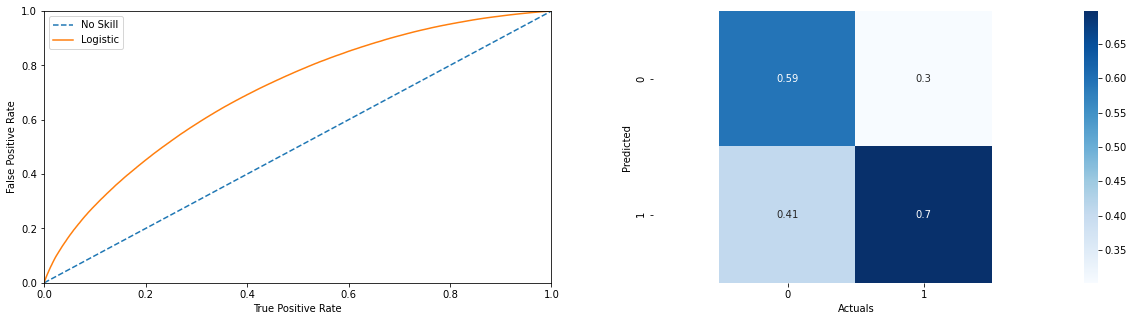

In [89]:
plot_ROC_Confusion(Xtrain,ytrain,modelSmote,best_threshold)

In [82]:
pd.DataFrame({"Feature":Xtrain.columns.tolist(),"Coefficients":modelSmote.coef_[0]})

,Feature,Coefficients
0,int_rate,-0.067436
1,annual_inc,-0.046384
2,dti,0.021243
3,inq_last_6mths,0.074030
4,revol_util,-0.014027
5,bc_open_to_buy,-0.067504
6,mo_sin_rcnt_rev_tl_op,-0.017674
7,mo_sin_rcnt_tl,-0.022452
8,mths_since_recent_bc,-0.064902
9,num_actv_rev_tl,0.058129


In [83]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

modelLDA = LinearDiscriminantAnalysis()
modelLDA.fit(X_train, y_train)


LinearDiscriminantAnalysis()

In [84]:

scores = cross_val_score(modelLDA, X_train , y_train, cv=5)
print(scores, np.mean(scores))

[0.69393135 0.69466245 0.69506677 0.69589756 0.69462753] 0.6948371314781163


In [85]:
fp, tp, threshold = roc_curve(ytrain, modelLDA.predict_proba(Xtrain)[:,1])

Sensitivity = tp
Specificity = 1-fp

Youden_J_stat = Sensitivity+Specificity-1

best_threshold_loc = np.argmax(Youden_J_stat)

best_threshold = threshold[best_threshold_loc]
print('Best threshold:', best_threshold)

Best threshold: 0.32410013440532953


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.703
Precision=0.34, Recall=0.34, F1=0.34


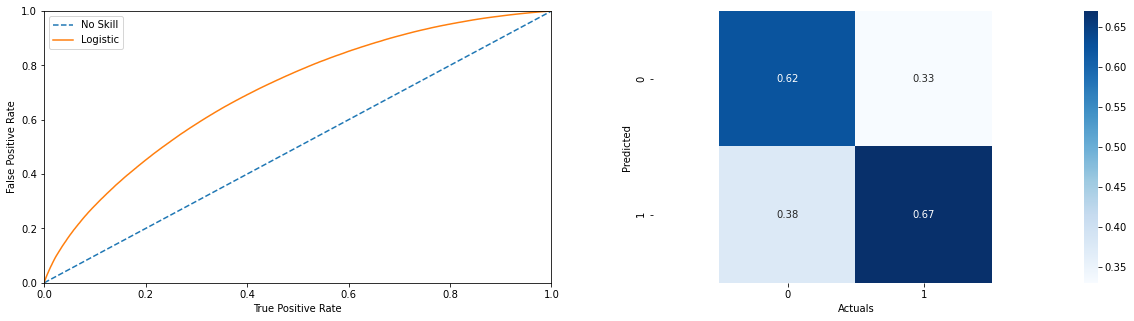

In [86]:
plot_ROC_Confusion(Xtest,ytest,modelLDA,best_threshold)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.702
Precision=0.34, Recall=0.34, F1=0.34


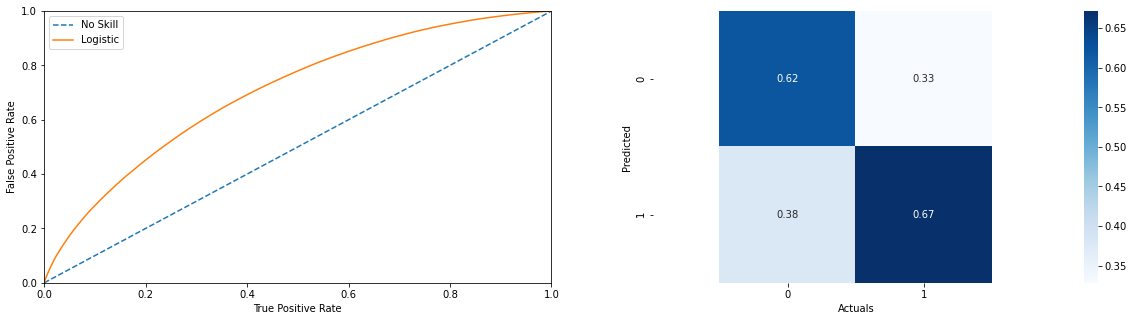

In [87]:
plot_ROC_Confusion(Xtrain,ytrain,modelLDA,best_threshold)

In [124]:
from sklearn.ensemble import RandomForestClassifier


modelRF = RandomForestClassifier(n_estimators=500)
modelRF.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [125]:
scores = cross_val_score(modelRF, X_train , y_train, cv=5)
print(scores, np.mean(scores))

[0.70981052 0.71021484 0.71051947 0.71156626 0.78633619] 0.7256894576448704


In [126]:
fp, tp, threshold = roc_curve(ytrain, modelRF.predict_proba(Xtrain)[:,1])

Sensitivity = tp
Specificity = 1-fp

Youden_J_stat = Sensitivity+Specificity-1

best_threshold_loc = np.argmax(Youden_J_stat)

best_threshold = threshold[best_threshold_loc]
print('Best threshold:', best_threshold)

Best threshold: 0.632


No Skill: ROC AUC=0.500
RandomForestClassifier: ROC AUC=0.999
Precision=0.97, Recall=0.97, F1=0.97


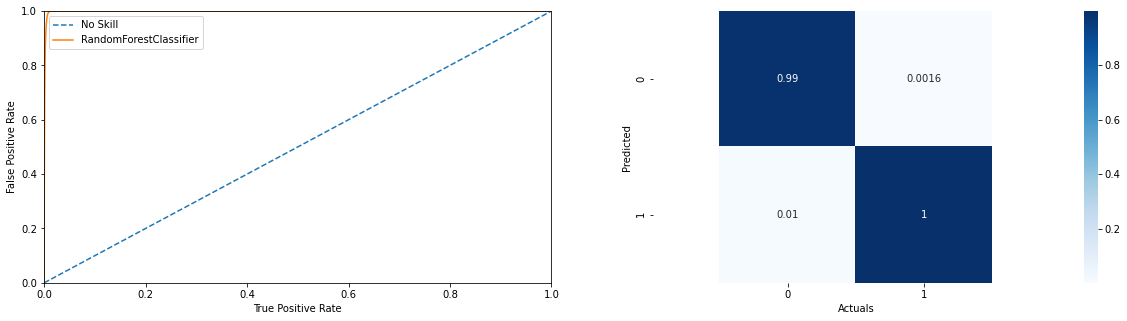

In [127]:
plot_ROC_Confusion(Xtrain,ytrain,modelRF,best_threshold)

No Skill: ROC AUC=0.500
RandomForestClassifier: ROC AUC=0.640
Precision=0.02, Recall=0.02, F1=0.02


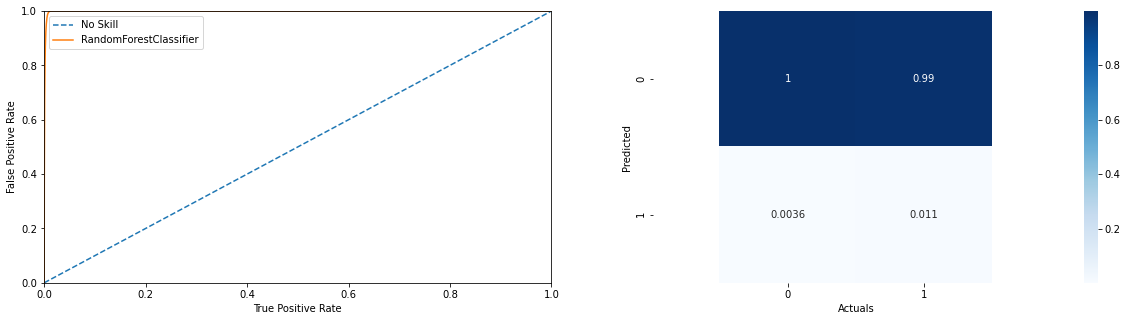

In [131]:
plot_ROC_Confusion(Xtest,ytest,modelRF,best_threshold)